# Imports

In [1]:
from itertools import combinations
import os
from pathlib import Path
from typing import Literal, Optional

from matplotlib import pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from utils_extraction import metrics

In [2]:
# increase figure size to (8, 8)
rcParams["figure.figsize"] = (8, 8)
rcParams["figure.dpi"] = 150
plt.style.use("ggplot")

# Constants

In [189]:
SAVE_DIR = Path("extraction_results")
EVAL_DIR = SAVE_DIR / "eval_v4"
DEBERTA = "deberta-v2-xxlarge-mnli"

DATASET_ORDER = ("imdb", "amazon-polarity", "ag-news", "dbpedia-14", "copa", "rte", "boolq", "qnli", "piqa", "all")
METHOD_ORDER = ("CCS", "LR", "CCS-md", "LR-md", "RCCS")

# Utils

In [209]:
# Data loading and preprocessing

def load_probs(
    model_name: str,
    train: str,
    test: str,
    method: str = "CCS",
    save_dir: Optional[Path] = None,
):
    save_dir = save_dir or SAVE_DIR

    dir = (save_dir / "rccs") if method.startswith("RCCS") else save_dir
    folder = dir / f"states_{model_name}_{method}" / train
    pattern = f"{test}*_{method}.csv" if test != "all" else f"*_{method}.csv"
    return pd.concat([pd.read_csv(f) for f in folder.glob(pattern)])


def get_best_metric_by_acc_df(df):
    """Flip metrics for each experiment if it improves in-domain accuracy.

    Use the in-domain accuracy to decide whether to flip the accuracy instead of
    computing max(acc, 1-acc) for test datasets even if the in-domain accuracy
    is greater than 0.5. Also flips the ECE if the flipped accuracy is better.
    """
    processed_df = []
    for key, exp_df in df.groupby(["model", "prefix", "method", "prompt_level"]):
        for train_ds in exp_df["train"].unique():
            train_df = exp_df[exp_df["train"] == train_ds].copy()
            if train_ds == "all":
                # If trained on all the datasets, use the mean accuracy on each
                # dataset to decide whether to flip the accuracy.
                in_domain_acc = train_df["accuracy"].mean()
                in_domain_ece = train_df["ece"].mean()
                in_domain_ece_flip = train_df["ece_flip"].mean()
            else:
                in_domain_acc = train_df[train_df["test"] == train_ds]["accuracy"]
                in_domain_ece = train_df[train_df["test"] == train_ds]["ece"]
                in_domain_ece_flip = train_df[train_df["test"] == train_ds]["ece_flip"]

                assert len(in_domain_acc) == 1
                assert len(in_domain_ece) == 1
                assert len(in_domain_ece_flip) == 1

                in_domain_acc = in_domain_acc.iloc[0]
                in_domain_ece = in_domain_ece.iloc[0]
                in_domain_ece_flip = in_domain_ece_flip.iloc[0]
            if in_domain_acc < 0.5:
                train_df["accuracy"] = 1 - train_df["accuracy"]
                train_df["ece"] = train_df["ece_flip"]

            del train_df["ece_flip"]
            processed_df.append(train_df)

    return pd.concat(processed_df)


def load_stats_dfs(
    model_name: str,
    train: Optional[str] = None,
    test: Optional[str] = None,
    method: Optional[str] = None,
    prefix: Optional[str] = None,
    save_dir: Optional[Path] = None,
    best_metric_by_acc: bool = True,
):
    save_dir = save_dir or SAVE_DIR

    if method is not None and method.startswith("RCCS"):
        dir = save_dir / "rccs"
    else:
        dir = save_dir

    if prefix is None:
        pattern = f"{model_name}*.csv"
    else:
        pattern = f"{model_name}_{prefix}_*.csv"
    csvs = dir.glob(pattern)
    dfs = [pd.read_csv(f) for f in csvs]

    if not dfs:
        raise ValueError(
            f"No csvs found for {model_name}, {train}, {test}, {method}"
        )

    # Filter by train & method
    if train is not None and train != "all":
        dfs = [df[df["train"] == train] for df in dfs]
    if method is not None:
        dfs = [df[df["method"] == method] for df in dfs]

    if test is not None and test != "all":
        # Filter by test
        dfs = [df[df["test"] == test] for df in dfs]
        assert all(len(df) == 1 for df in dfs)

    if best_metric_by_acc:
        dfs = [get_best_metric_by_acc_df(df) for df in dfs]

    return dfs


def load_stats(
    model_name: str,
    train: str,
    test: str,
    method: str,
    prefix: str,
    save_dir: Optional[Path] = None,
):
    dfs = load_stats_dfs(model_name, train, test, method, prefix, save_dir=save_dir)
    # If test = "all", average across all test datasets for each seed.
    # Otherwise, return the stats for the single test dataset for each seed.
    return {
        k: np.array([df[k].mean() for df in dfs])
        for k in ["accuracy", "loss", "cons_loss", "sim_loss"]
        if all(k in df.columns for df in dfs)
    }  # k: (seeds,)


# Inference

InferenceMethodType = Literal["auto", "mean", "class0", "class1"]

def get_single_class_probs(probs_df: np.ndarray, method: str, inference_method: InferenceMethodType = "auto"):
    """Returns the predicted probability for a single class."""
    if method == "LR":
        if inference_method not in ("auto", "class1"):
            raise ValueError(f"Unsupported inference method {inference_method} for method {method}")
        probs = probs_df.prediction
    elif method == "CCS":
        if inference_method == "auto" or inference_method == "mean":
            # Arbitrarily treat p0 as 0 and p1 as 1 to match the original CCS
            # implementation, which computes (p0 + 1 - p1) / 2 but then checks
            # if this value is < 0.5 intead of > 0.5.
            probs = (probs_df.p1 + 1 - probs_df.p0) / 2
        elif inference_method == "class0":
            probs = probs_df.p0
        elif inference_method == "class1":
            probs = probs_df.p1
    else:
        raise ValueError(f"Unknown method {method}")

    return probs.values.astype(np.float32)


# ECE

def calibration_plot(probabilities, labels, num_bins=10, title="Calibration Plot"):
    """
    Create a calibration plot using Seaborn.

    Args:
    - probabilities (array-like): Predicted probabilities for each sample, in the range [0, 1].
    - labels (array-like): True labels for each sample, in {0, 1}.
    - num_bins (int): Number of bins to divide the interval [0, 1].
    """
    ece, bin_mean_probs, bin_mean_labels = expected_calibration_error(probabilities, labels, num_bins=num_bins)
    calibration_plot_from_bin_xy(bin_mean_probs, bin_mean_labels, title=f"{title} (ECE: {ece:.4f})")


def calibration_plot_from_bin_xy(bin_mean_probs, bin_mean_labels, title="Calibration Plot", ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    sns.lineplot(x=bin_mean_probs, y=bin_mean_labels, marker='o', ax=ax)
    ax.plot([0, 1], [0, 1], 'k--')  # Perfect calibration line
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Mean Label')
    ax.set_title(title)
    ax.grid(True)


def expected_calibration_error(probs, labels, num_bins=10):
    """
    Calculate the Expected Calibration Error (ECE) of a classification model.

    Args:
    - probs (array-like): Predicted probabilities for each sample, in the range [0, 1].
    - labels (array-like): True labels for each sample, in {0, 1}.
    - num_bins (int): Number of bins to divide the interval [0, 1].

    Returns:
    - ece (float): Expected Calibration Error.
    """
    probs = np.asarray(probs)
    labels = np.asarray(labels)

    # Ensure the inputs have the same length
    assert probs.shape[0] == labels.shape[0], "Number of probabilities and labels must be the same."

    # Calculate the bin boundaries
    percentiles = np.linspace(0, 100, 11)
    bin_boundaries = np.percentile(probs, percentiles)

    # Initialize variables to store total confidence and accuracy in each bin
    bin_mean_probs = np.zeros(num_bins)
    bin_mean_labels = np.zeros(num_bins)
    bin_samples = np.zeros(num_bins)

    # Assign each prediction to its corresponding bin
    bin_indices = np.digitize(probs, bin_boundaries) - 1

    # Compute the total confidence and accuracy in each bin
    for i in range(num_bins):
        bin_mask = bin_indices == i
        bin_samples[i] = np.sum(bin_mask)
        if bin_samples[i] > 0:
            bin_mean_probs[i] = np.mean(probs[bin_mask])
            bin_mean_labels[i] = np.mean(labels[bin_mask])

    # Remove empty bins
    non_empty_bins = bin_samples > 0
    bin_mean_probs = bin_mean_probs[non_empty_bins]
    bin_mean_labels = bin_mean_labels[non_empty_bins]
    bin_samples = bin_samples[non_empty_bins]

    ece = np.average(np.abs(bin_mean_labels - bin_mean_probs), weights=bin_samples / np.sum(bin_samples))

    return ece, bin_mean_probs, bin_mean_labels

# Load data

In [195]:
stats_dfs = load_stats_dfs(DEBERTA, save_dir=EVAL_DIR, best_metric_by_acc=True)

In [196]:
raw_stats_dfs = load_stats_dfs(DEBERTA, save_dir=EVAL_DIR, best_metric_by_acc=False)

# Transfer accuracy

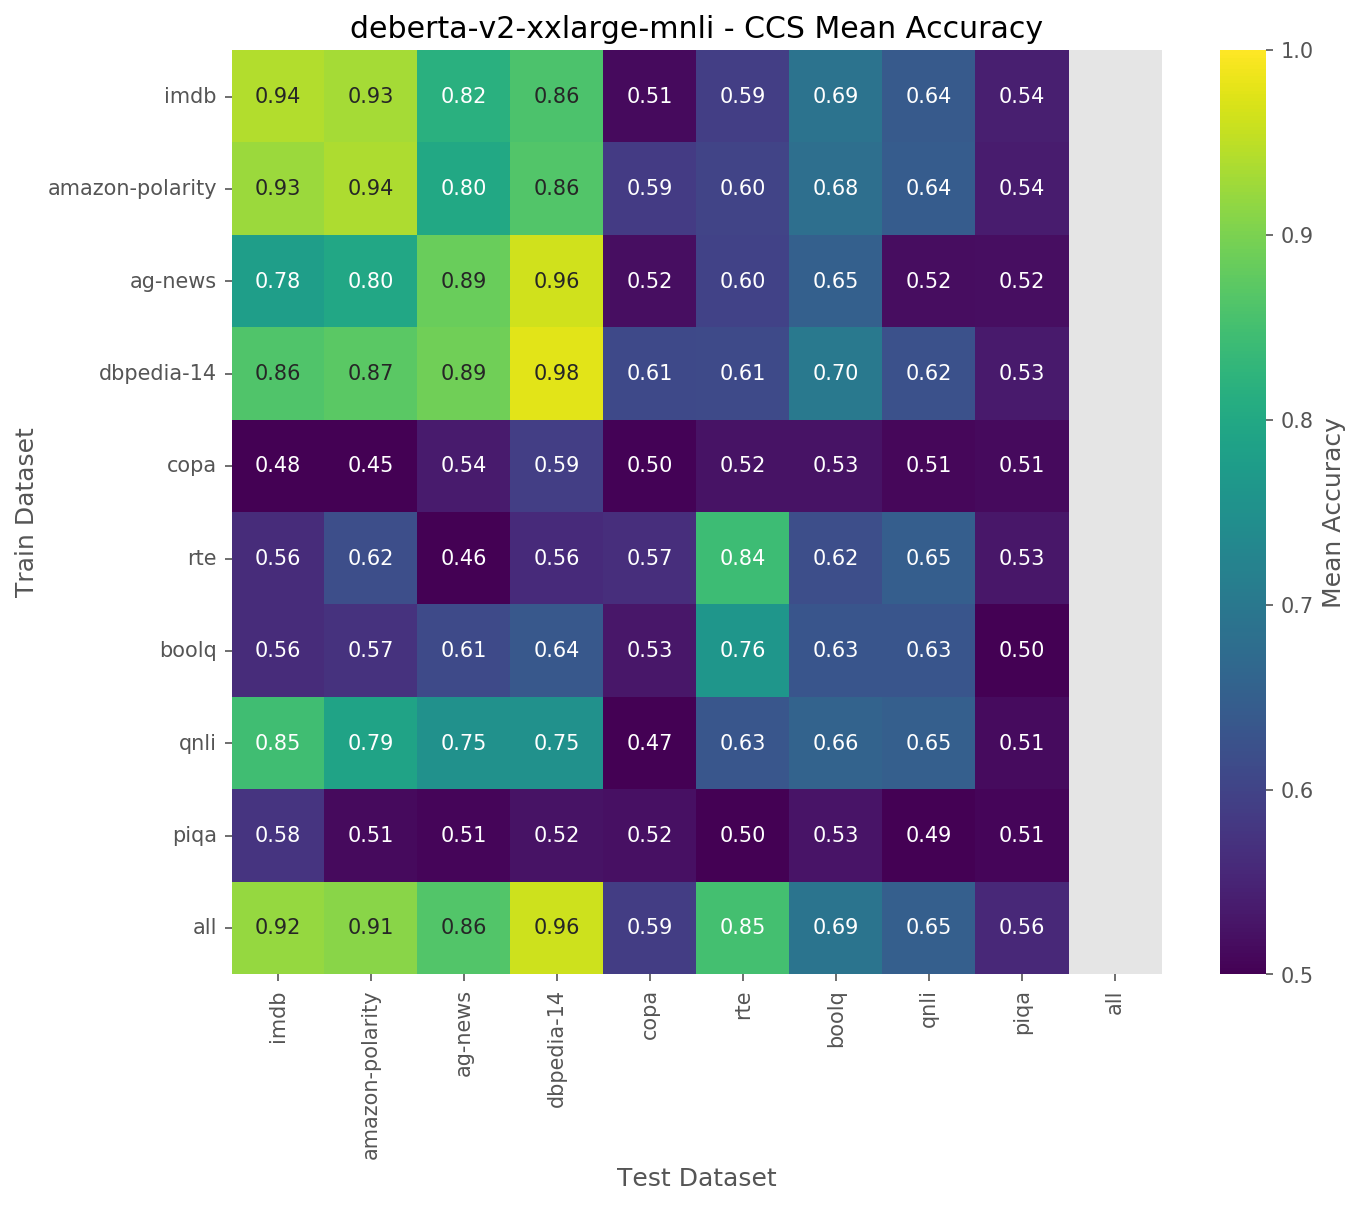

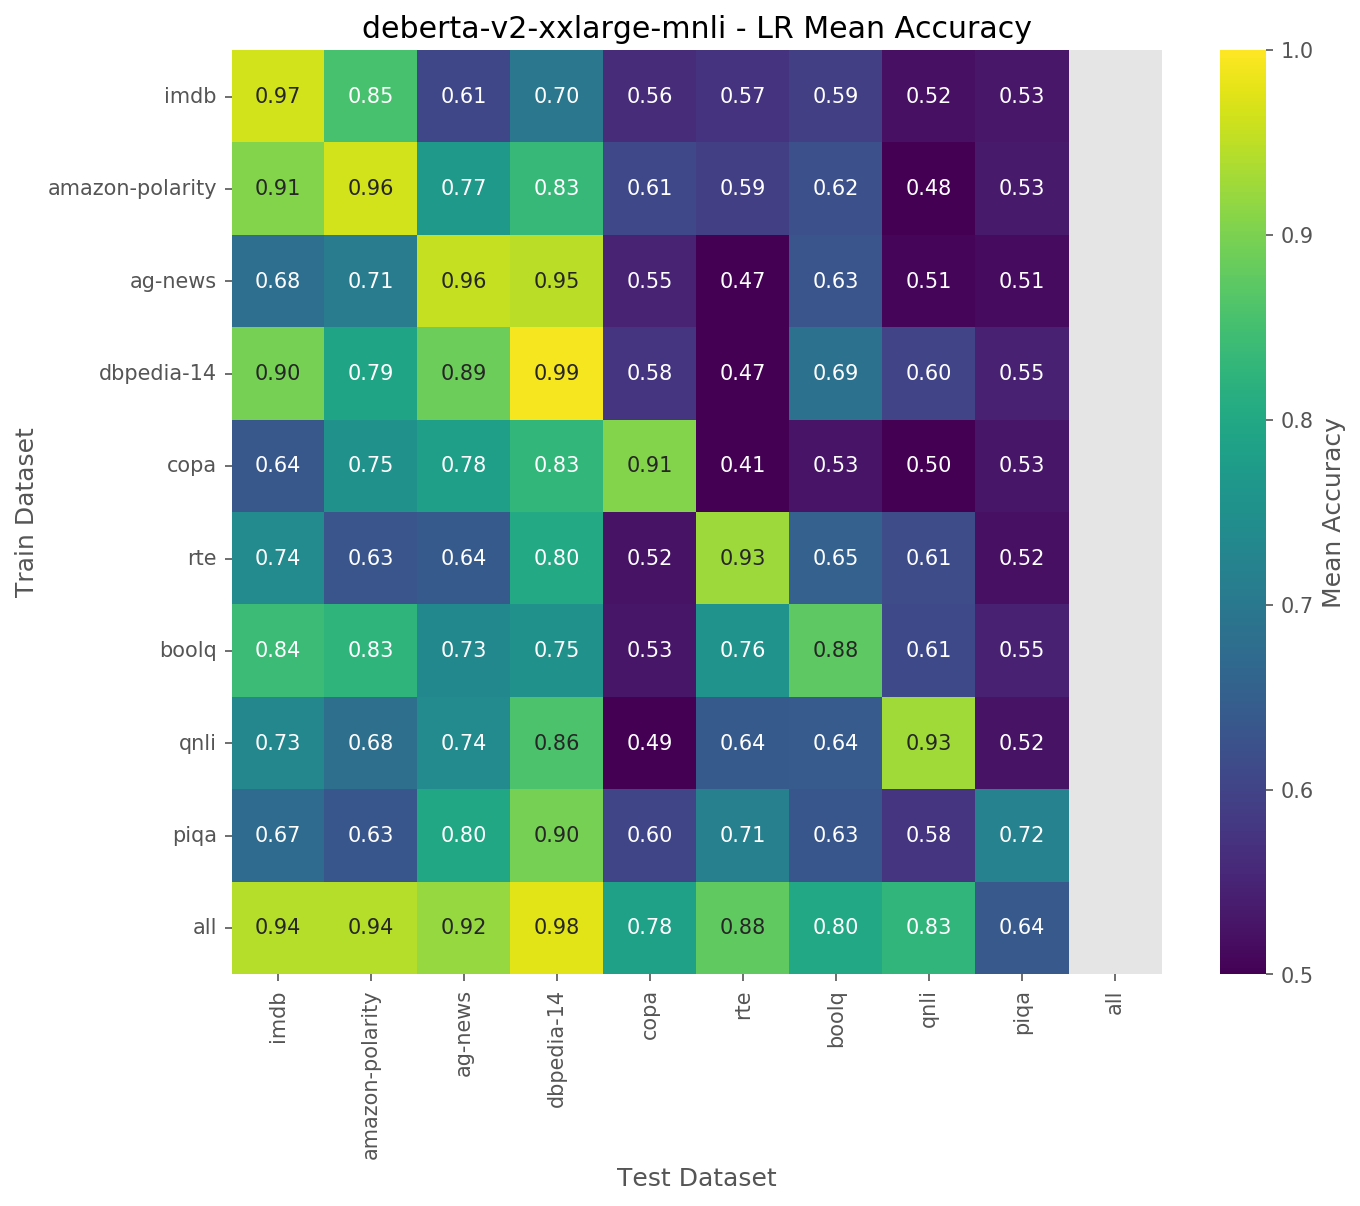

In [201]:
prefix = "normal"
std_annot = False

# Filter DataFrames to only include rows with prefix "normal"
filtered_data = []
for df in stats_dfs:
    prefix_df = df[df["prefix"] == prefix]
    if not prefix_df.empty:
        filtered_data.append(prefix_df)

# Combine filtered DataFrames into a single DataFrame
combined_df = pd.concat(filtered_data, ignore_index=True)

# Calculate mean accuracy and standard deviation of accuracy for each combination
agg_df = combined_df.groupby(['model', 'method', 'train', 'test']).agg(
    mean_accuracy=('accuracy', 'mean'),
    std_accuracy=('accuracy', 'std')
).reset_index()

for model in agg_df.model.unique():
    model_df = agg_df[agg_df['model'] == model]
    for method in METHOD_ORDER:
        df = model_df[model_df['method'] == method]
        if len(df) == 0:
            continue

        # Modify the pivot table creation to include both mean accuracy and std accuracy in the annotations
        pivot_table_mean = df.pivot("train", "test", "mean_accuracy").reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
        pivot_table_std = df.pivot("train", "test", "std_accuracy").reindex(index=DATASET_ORDER, columns=DATASET_ORDER)

        # Reorder the pivot tables according to DATASET_ORDER
        pivot_table_mean_ordered = pivot_table_mean.reindex(index=DATASET_ORDER, columns=DATASET_ORDER)
        pivot_table_std_ordered = pivot_table_std.reindex(index=DATASET_ORDER, columns=DATASET_ORDER)

        # Combine mean and std into a single string for each cell annotation
        annotations = pivot_table_mean.applymap("{:.2f}".format)
        if std_annot:
            annotations += "+-" + pivot_table_std.applymap("{:.2f}".format)
            annot_size = 6
        else:
            annot_size = 10

        # Create the heatmap with custom annotations
        plt.figure(figsize=(10, 8))
        sns.heatmap(pivot_table_mean, annot=annotations, fmt="", cmap="viridis",
                    cbar_kws={'label': 'Mean Accuracy'}, vmin=0.5, vmax=1, annot_kws={"size": annot_size})

        # Adding title and axis labels
        plt.title(f'{model} - {method} Mean Accuracy')
        plt.xlabel('Test Dataset')
        plt.ylabel('Train Dataset')

        # Show the plot
        plt.show()


# ECE

In [198]:
# Get ECE, probabilities, and labels for each experiment.

rows = []

for name in os.listdir(EVAL_DIR):
    subdir = os.path.join(EVAL_DIR, name)
    if os.path.isdir(subdir) and name.startswith("states"):
        _, model, method, seed = name.split("_")
        seed = int(seed)
        for train_set in os.listdir(subdir):
            train_dir = os.path.join(subdir, train_set)
            for probs_file in os.listdir(train_dir):
                if probs_file.endswith(".csv"):
                    test_set, prompt, test_method = probs_file[:-4].split("_")
                    assert test_method == method, f"test method ({test_method}) does not match method {method}"
                    probs_file_path = os.path.join(train_dir, probs_file)
                    probs_df = pd.read_csv(probs_file_path)
                    probs = get_single_class_probs(probs_df, method)
                    preds = (probs > 0.5).astype(int)
                    labels = probs_df.label.values
                    acc = (preds == labels).mean()
                    ece, bin_mean_probs, bin_mean_labels = expected_calibration_error(probs, labels)
                    ece_flip, bin_mean_probs_flip, bin_mean_labels_flip = expected_calibration_error(1 - probs, labels)
                    rows.append([model, method, train_set, test_set, int(prompt), seed, acc, ece, bin_mean_probs, bin_mean_labels, False])
                    rows.append([model, method, train_set, test_set, int(prompt), seed, 1 - acc, ece_flip, bin_mean_probs_flip, bin_mean_labels_flip, True])

ece_df = pd.DataFrame(rows, columns=["model", "method", "train", "test", "prompt", "seed", "acc", "ece", "bin_mean_probs", "bin_mean_labels", "flip_probs"])

# Pivot if needed.
# pivoted_ece_df = ece_df.pivot(index=['model', 'method', 'train', 'test', 'prompt', 'seed'],
#                       columns='flip_probs',
#                       values=['acc', 'ece'])

# # Flatten the multi-level columns
# pivoted_ece_df.columns = ['_'.join(map(str, col)).strip() for col in pivoted_ece_df.columns.values]

# # Rename the columns
# pivoted_ece_df = pivoted_ece_df.rename(columns={'acc_False': 'acc',
#                                         'acc_True': 'acc_flip',
#                                         'ece_False': 'ece',
#                                         'ece_True': 'ece_flip'})

In [210]:
# Mean accuracy and ECE over the prompts. Can be used to compare with CSV results.
mean_ece_df = ece_df[["model", "method", "train", "test", "prompt", "seed", "flip_probs", "acc", "ece"]].groupby(
    ["model", "method", "train", "test", "seed", "flip_probs"]).agg(
        {"acc": "mean", "ece": "mean"}
    )
mean_ece_df.head()

acc  \
model                   method train   test            seed flip_probs             
deberta-v2-xxlarge-mnli CCS    ag-news ag-news         0    False       0.122500   
                                                            True        0.877500   
                                                       1    False       0.895000   
                                                            True        0.105000   
                                       amazon-polarity 0    False       0.264091   

                                                                             ece  
model                   method train   test            seed flip_probs            
deberta-v2-xxlarge-mnli CCS    ag-news ag-news         0    False       0.702828  
                                                            True        0.055154  
                                                       1    False       0.063957  
                                                            True        0.723310  
                                       amazon-polarity 0    False       0.347524

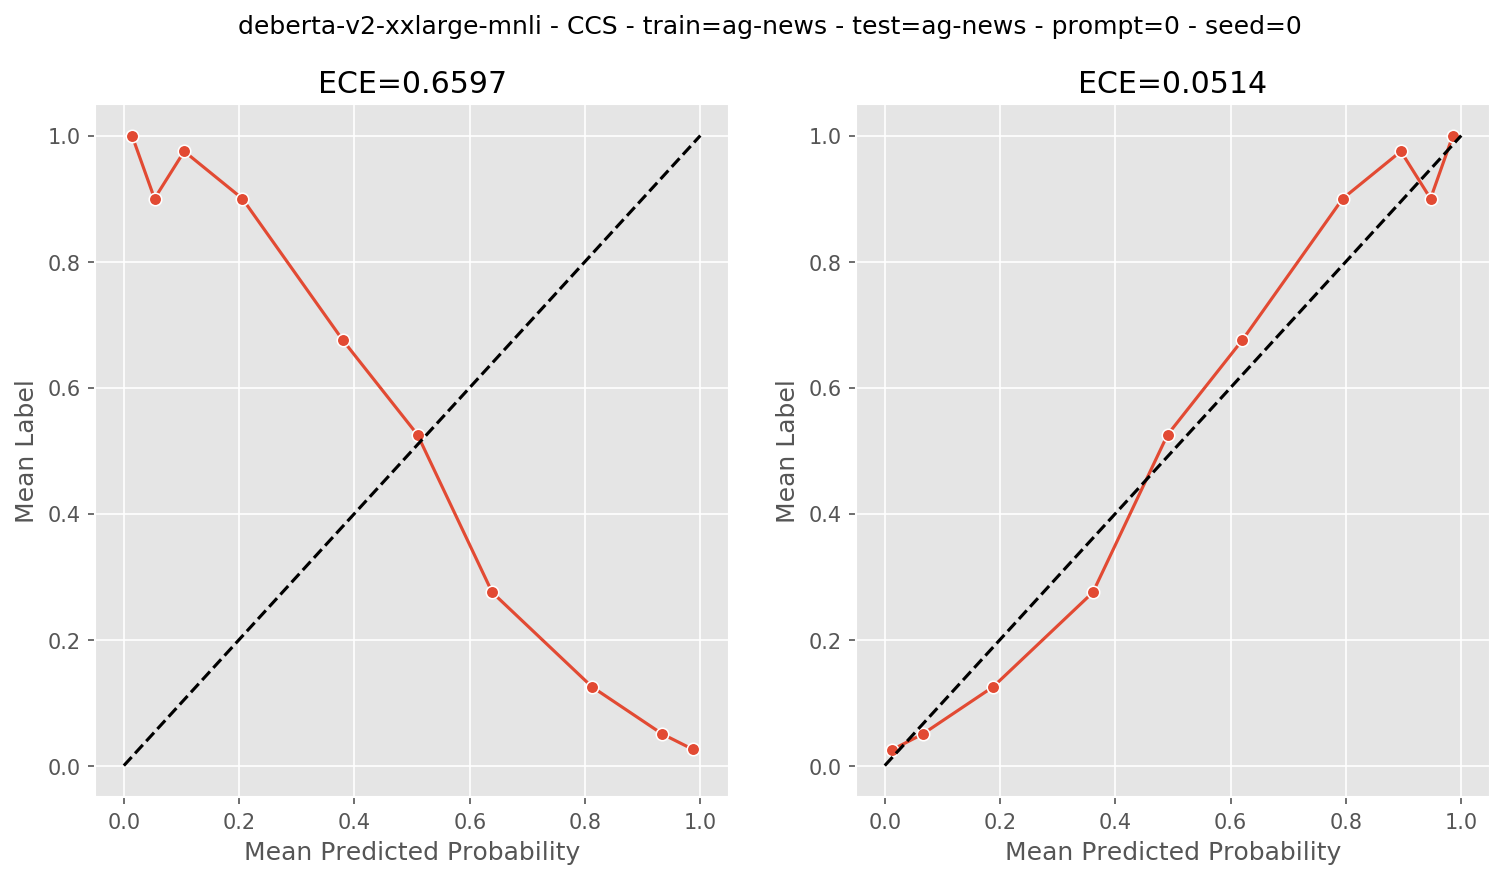

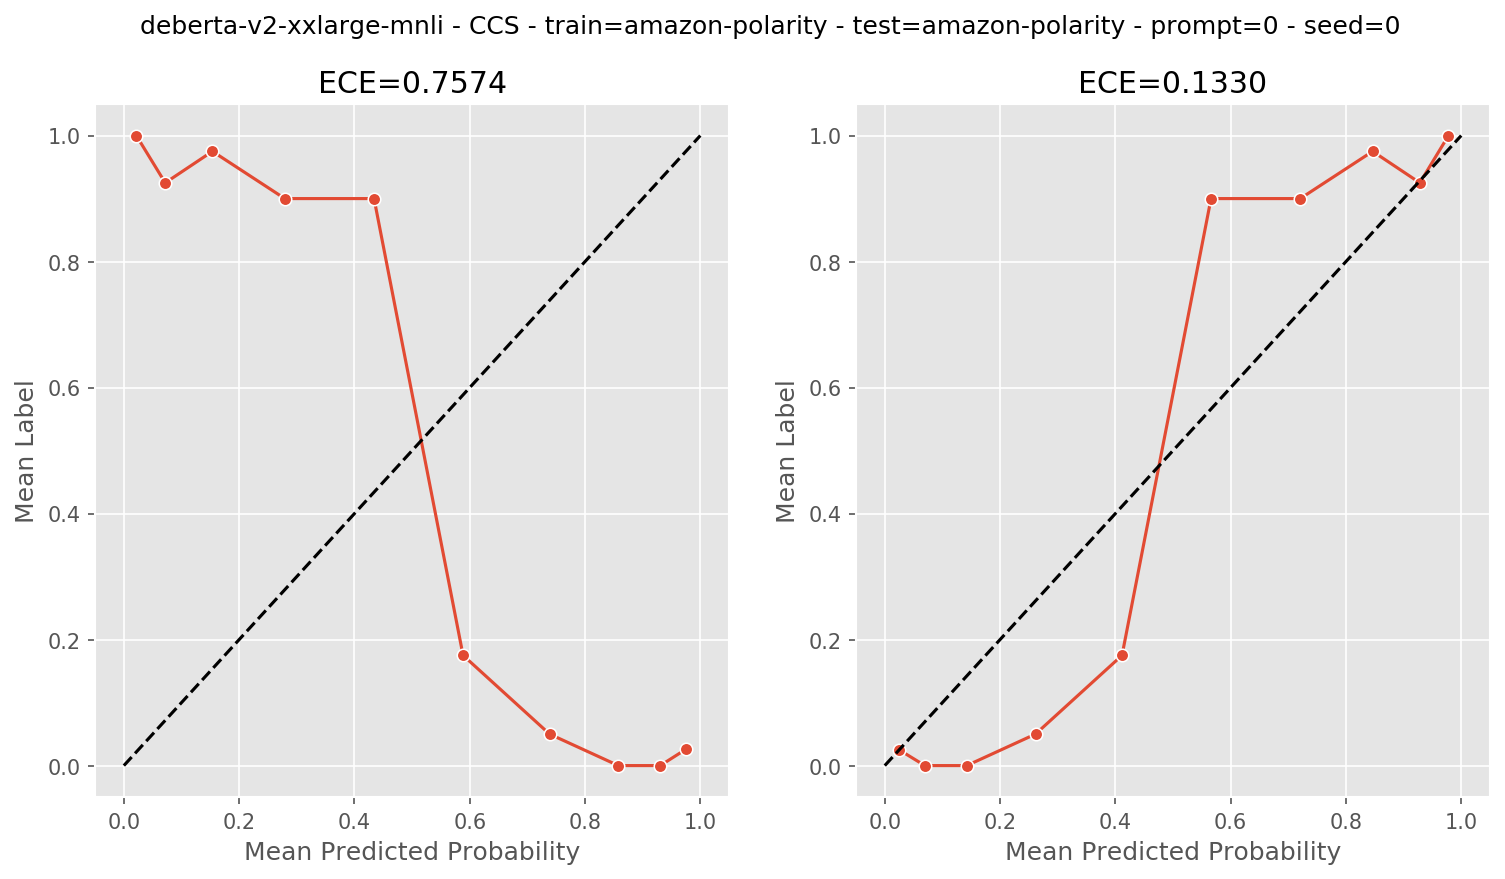

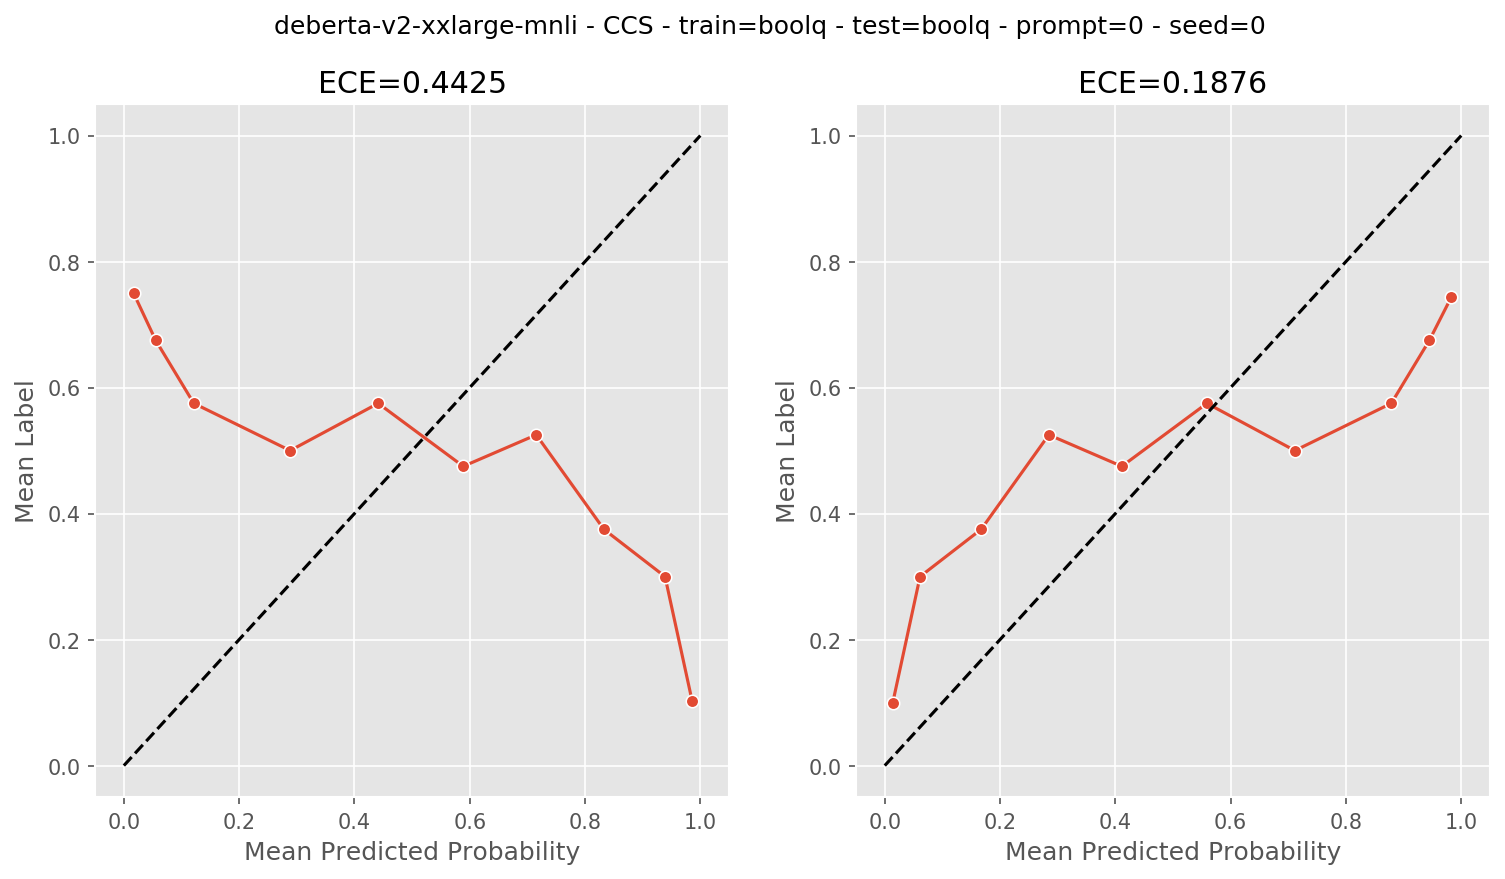

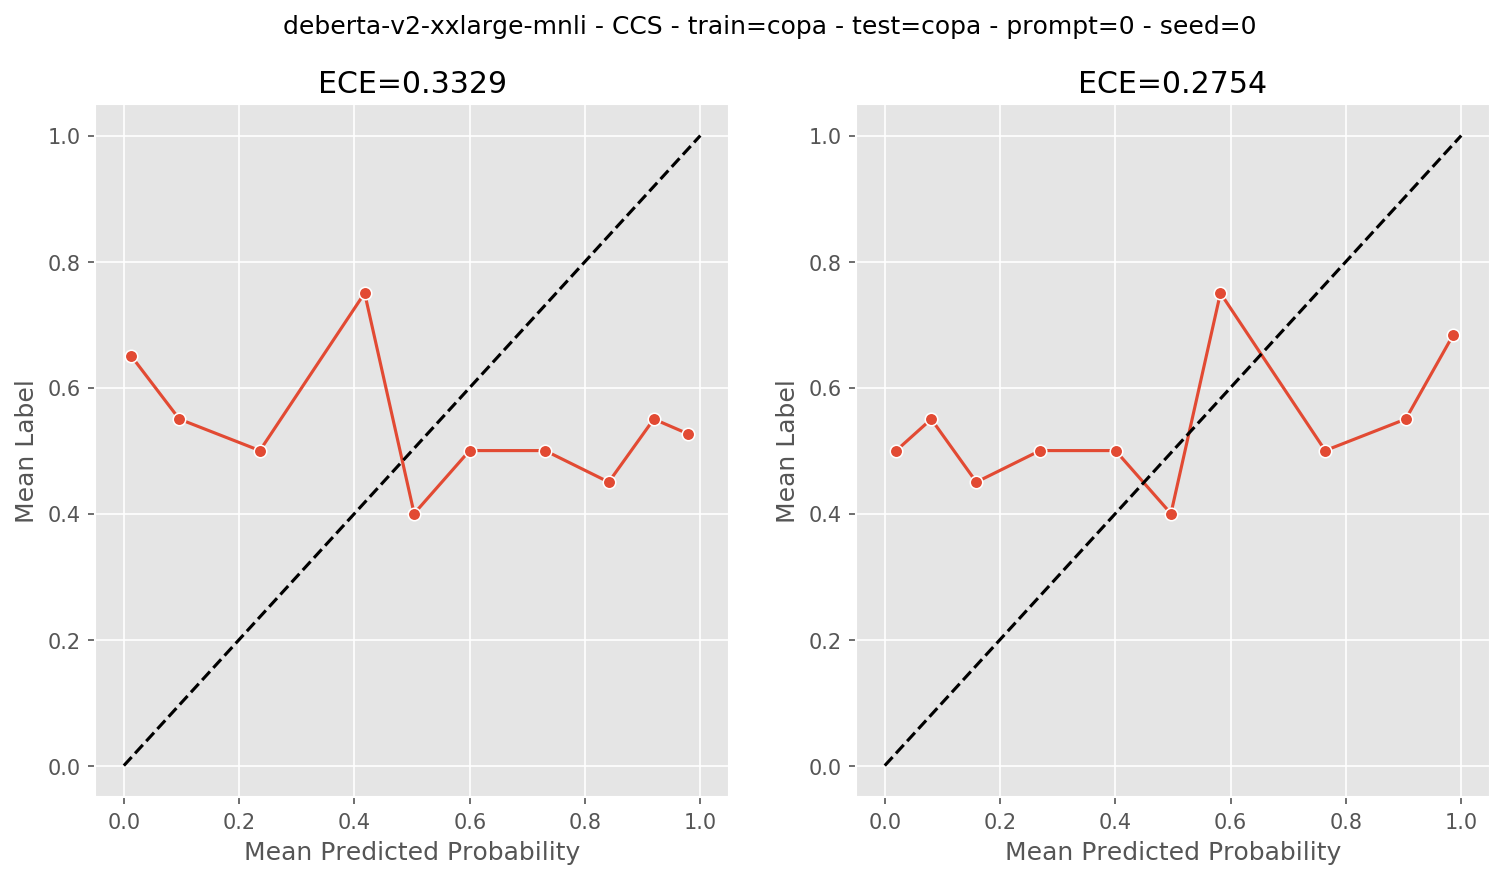

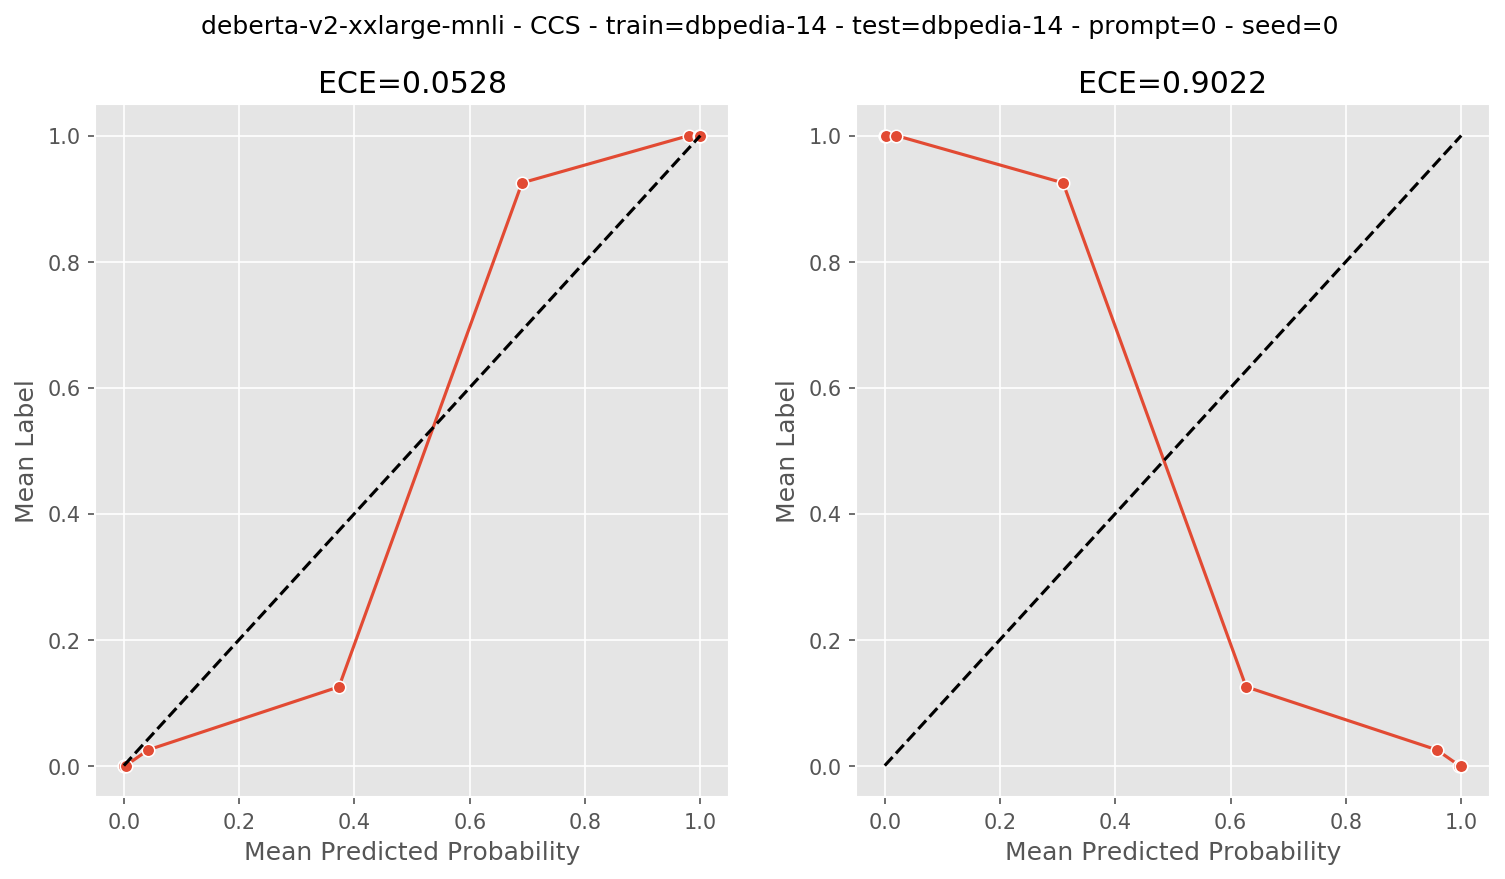

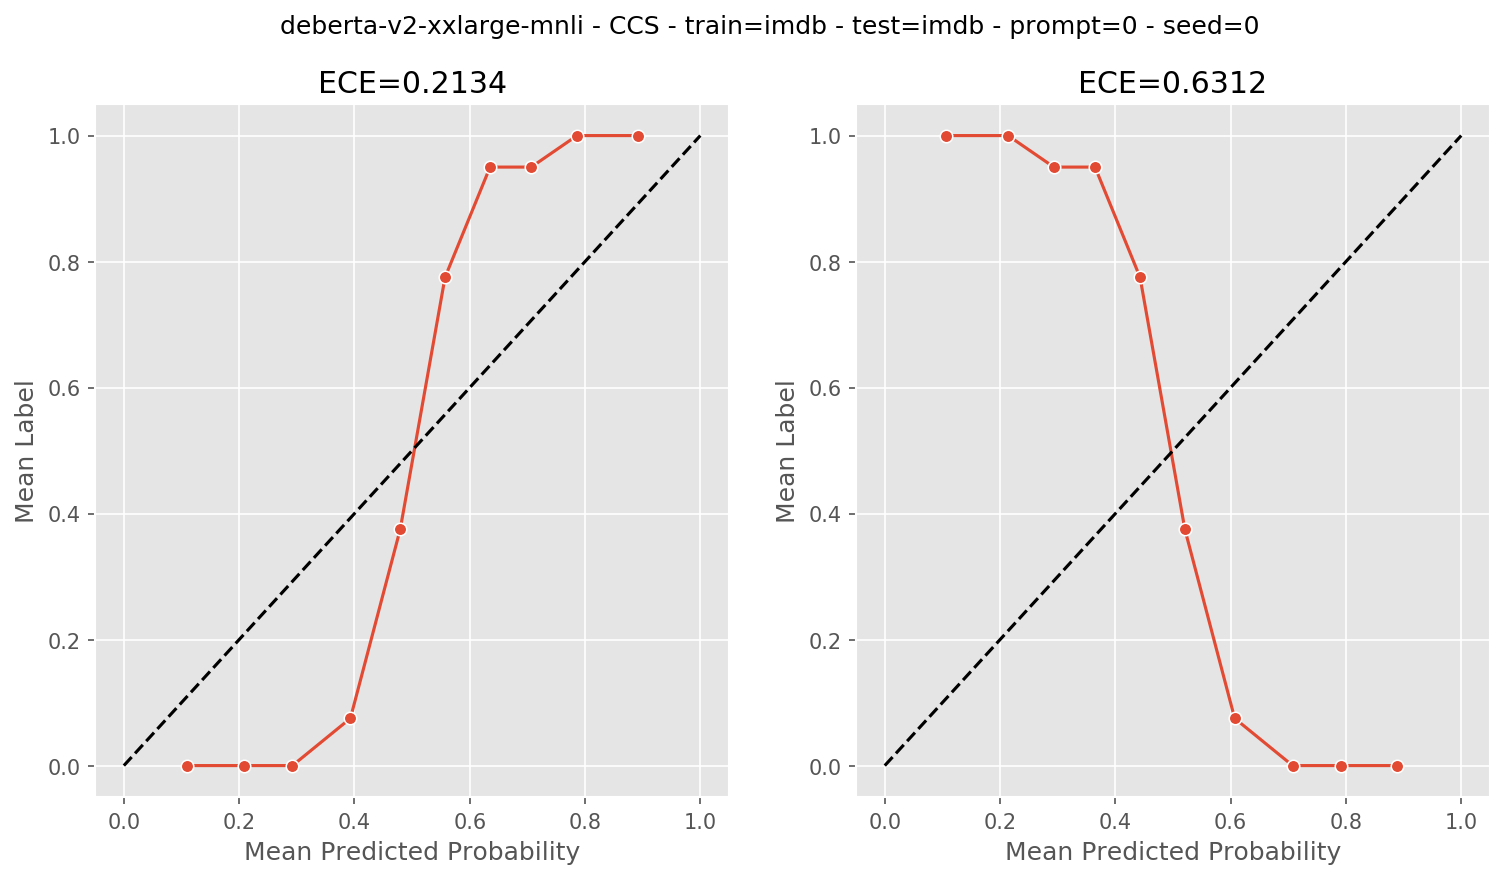

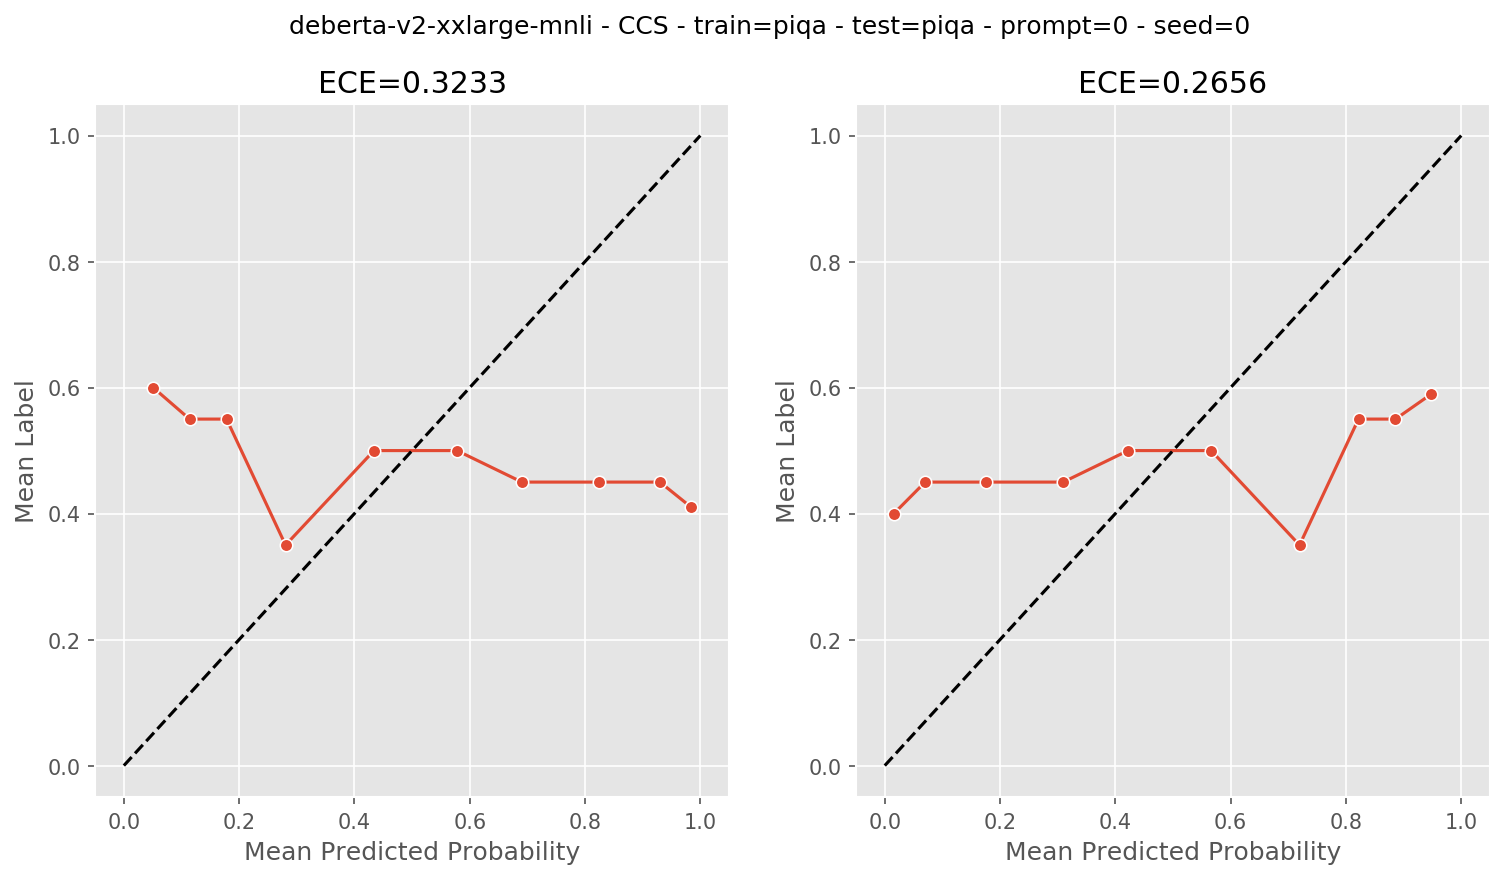

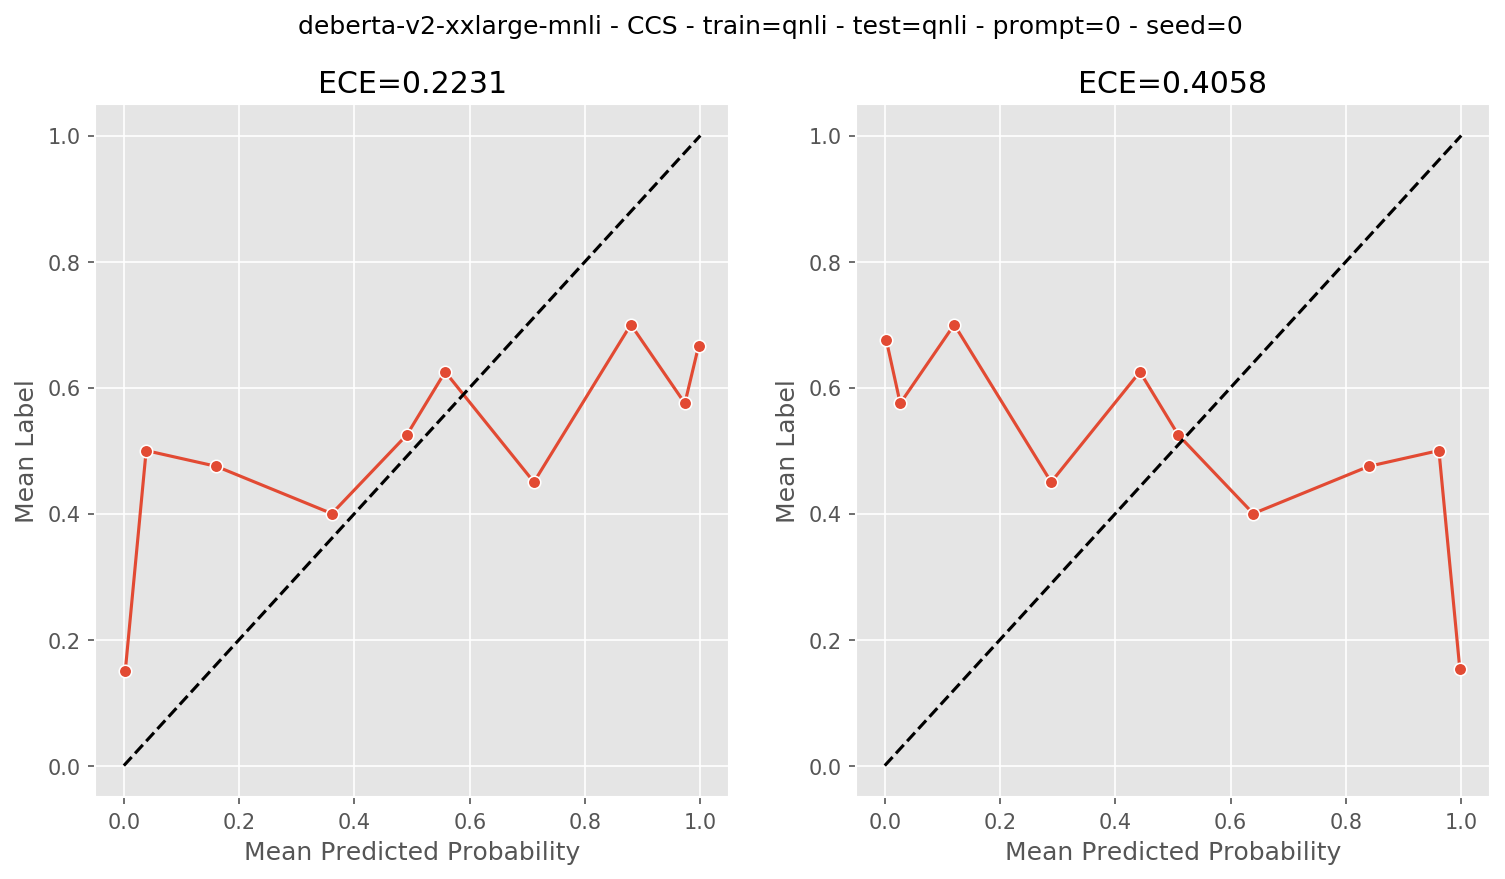

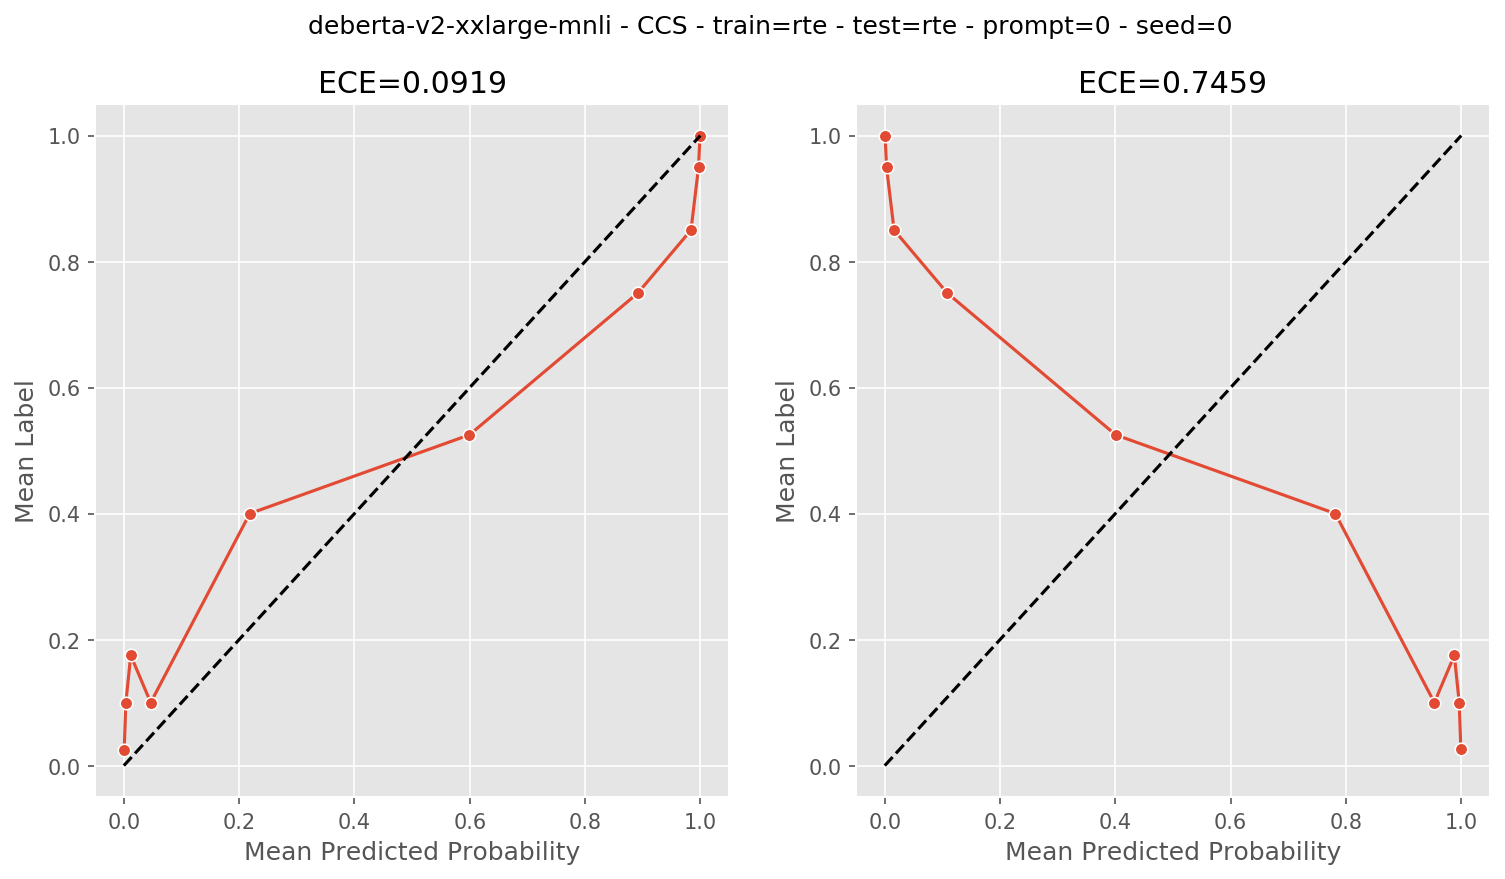

In [213]:
sample_ece_df = ece_df.query("method == 'CCS' and train == test and seed == 0 and prompt == 0")
for key, group_df in sample_ece_df.groupby(["model", "method", "train", "test", "prompt", "seed"]):
    assert len(group_df) == 2
    og_row = group_df[~group_df["flip_probs"]].iloc[0]
    flip_row = group_df[group_df["flip_probs"]].iloc[0]

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    og_title = f"ECE={og_row.ece:.4f}"
    calibration_plot_from_bin_xy(og_row.bin_mean_probs, og_row.bin_mean_labels, og_title, ax=ax[0])

    flip_title = f"ECE={flip_row.ece:.4f}"
    calibration_plot_from_bin_xy(flip_row.bin_mean_probs, flip_row.bin_mean_labels, flip_title, ax=ax[1])

    title=f"{og_row.model} - {og_row.method} - train={og_row.train} - test={og_row.test} - prompt={og_row.prompt} - seed={og_row.seed}"
    fig.suptitle(title)